In [1]:
%matplotlib inline  
import csv
import pickle
import numpy as np
import matplotlib.pyplot as pl
from scipy.integrate import simps
from scipy.interpolate import interp1d
from collections import namedtuple
import itertools
import datetime as dt
import scipy.stats as stats
from scipy.interpolate import interp1d
import scipy.signal as signal

In [2]:
filename='dndz_LSST_i27_SN5_3y'
f = open(filename+".csv_manually_extrapolated")
csv_f = csv.reader(f)


In [3]:
z =[]
dn=[]
for row in csv_f:
    z+=[float(row[0])]
    dn+=[float(row[1])]
z = np.asarray(z)
dn= np.asarray(dn)
dn[0]=0

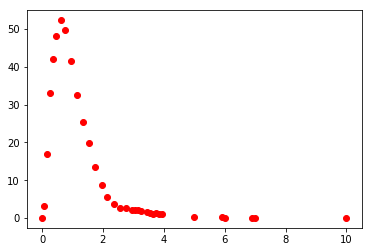

In [4]:
pl.figure()
pl.plot(z,dn,'ro')
pl.show()

In [5]:
interp_dn=interp1d(z, dn, kind='linear')
norm=simps(interp_dn(z),z)
norm

65.672302580174119

In [ ]:
#save csv file as pkl
pickle.dump([z,dn],open(filename+'tot_extrapolated.pkl','w'))

In [ ]:
#z_min,width,sigma smoothing
bin0=[0,0.5,0.03]
bin1=[0.5,0.5,0.03]
bin2=[1.,1.,0.04]
bin3=[2.,1.,0.05]
bin4=[3.,1.,0.05]

#Gaussian with z=dependent variance: sigma(z)=(1+z)*sigma
def gauss(x,errscale):
    var =(errscale*(1.+x))**2
    res = np.exp(-x**2/2./var)
    norm= simps(res,x)
    return res/norm

delta = 1e-4
big_grid = np.arange(-6,6,delta)

In [ ]:
c=['b','g','c','m','g']
ii=0

fig = pl.figure(figsize = (6,4))
ax = fig.add_subplot(111)
ax.plot(z,dn,color='k')

res=[]
bins=[bin0,bin1,bin2,bin3,bin4]

for mbin in bins:
    z_      = np.linspace(mbin[0],mbin[0]+mbin[1],100)
    dndz    = interp_dn(z_)
    dndz    = interp1d(z_, dndz, kind='linear',bounds_error=False,fill_value=0.)
    norm    = simps(dndz(big_grid),big_grid)
    print norm
    errscale= mbin[2]
    
    pmf1 = dndz(big_grid)*delta
    pmf2 = gauss(big_grid,errscale)*delta
    
    conv_pmf = signal.fftconvolve(pmf1,pmf2,'same')/delta
    print norm/simps(conv_pmf,big_grid)
    bin_ = interp1d(big_grid,conv_pmf,kind='linear',bounds_error=False,fill_value=0.)
    
    ax.fill_between(z_,0,bin_(z_),color=c[ii],alpha=0.3,interpolate=True)
    ii+=1
    res+=[conv_pmf]
ax.set_xlim(0,5)


pickle.dump([bins,big_grid,res],open(filename+'_extrapolated.pkl','w'))


In [ ]:
for mbin in [bin0,bin1,bin2]:
    simple = stats.uniform(loc=mbin[0],scale=bin0[1])

    pmf1 = simple.pdf(big_grid)*delta
    pmf2 = gauss(big_grid,errscale)*delta
    conv_pmf = signal.fftconvolve(pmf1,pmf2,'same') # Convolved probability mass function

    conv_pmf = conv_pmf/sum(conv_pmf)

    pl.plot(big_grid,pmf1/delta, label='Tophat')
    #pl.plot(big_grid,pmf2/delta, label='Gaussian error')
    pl.plot(big_grid,conv_pmf/delta, label='Sum')
    pl.xlim(-1,max(big_grid))
    #pl.legend(loc='best'), pl.suptitle('PMFs')
    pl.ylim(-0.5,3)
    
    print simps(conv_pmf/delta,big_grid)
    print simps(pmf1/delta,big_grid)
    print simps(pmf2/delta,big_grid)
    

In [ ]:
#pl.plot(big_grid,pmf1/delta, label='Tophat')
#pl.plot(big_grid,pmf2/delta, label='Gaussian error')

